# Tutorial 1: Physics Informed Neural Networks on PINA

In this tutorial we will show the typical use case of PINA on a toy problem solved by Physics Informed Problems. Specifically, the tutorial aims to introduce the following topics:

* Defining a PINA Problem,
* Build a `PINN` Solver,

We will show in detailed each step, and at the end we will solve a very simple problem with PINA.

## Defining a Problem

### Initialize the Problem class
The problem definition in the PINA framework is done by building a phython `class`, inherited from `AbsractProblem`. A problem is an object which explains what the solver is supposed to solve. For Physics Informed Neural Networks, a problem can be inherited from one or more problem (already implemented) classes (`SpatialProblem`, `TimeDependentProblem`, `ParametricProblem`), depending on the nature of the problem treated. 
Let's see an example to better understand:
#### Simple Ordinary Differential Equation
Consider the following:

$$
\begin{equation}
\begin{cases}
\frac{d}{dx}u(x) &=  u(x) \quad x\in(0,1)\\
u(x=0) &= 1 \\
\end{cases}
\end{equation}
$$

with analytical solution $u(x) = e^x$. In this case we have that our ODE depends only on the spatial variable $x\in(0,1)$ , this means that our problem class is going to be inherited from `SpatialProblem` class:

```python
from pina.problem import SpatialProblem
from pina.geometry import CartesianDomain

class SimpleODE(SpatialProblem):
    
    output_variables = ['u']
    spatial_domain = CartesianDomain({'x': [0, 1]})

    # other stuff ...
```

Notice that we define `output_variables` as a list of symbols, indicating the output variables of our equation (in this case only $u$). The `spatial_domain` variable indicates where the sample points are going to be sampled in the domain, in this case $x\in(0,1)$

What about if we also have a time depencency in the equation? Well in that case our `class` will inherit from both `SpatialProblem` and `TimeDependentProblem`:
```python
from pina.problem import SpatialProblem, TimeDependentProblem
from pina.geometry import CartesianDomain

class TimeSpaceODE(SpatialProblem, TimeDependentProblem):
    
    output_variables = ['u']
    spatial_domain = CartesianDomain({'x': [0, 1]})
    temporal_domain = CartesianDomain({'x': [0, 1]})

    # other stuff ...
```
where we have included the `temporal_domain` variable indicating the time domain where we want the solution.

Summarizing, in PINA we can initialize a problem with a class which is inherited from three base classes: `SpatialProblem`, `TimeDependentProblem`, `ParametricProblem`, depending on the type of problem we are considering. For reference:
* `SpatialProblem` $\rightarrow$ spatial variable(s) presented in the differential equation
* `TimeDependentProblem` $\rightarrow$ time variable(s) presented in the differential equation
* `ParametricProblem` $\rightarrow$ parameter(s) presented in the differential equation


### Write the problem class

Once the problem class is initialized we need to write the differential equation in PINA language. For doing this we need to load the pina operators found in `pina.operators` module. Let's again consider the Equation (1) and try to write the PINA model class:

In [2]:
from pina.problem import SpatialProblem
from pina.operators import grad
from pina.geometry import CartesianDomain
from pina.equation import Equation
from pina import Condition

import torch


class SimpleODE(SpatialProblem):

    output_variables = ['u']
    spatial_domain = CartesianDomain({'x': [0, 1]})

    # defining the ode equation
    def ode_equation(input_, output_):

        # computing the derivative
        u_x = grad(output_, input_, components=['u'], d=['x'])

        # extracting u input variable
        u = output_.extract(['u'])

        # calculate residual and return it
        return u_x - u

    # defining initial condition
    def initial_condition(input_, output_):
        
        # setting initial value
        value = 1.0

        # extracting u input variable
        u = output_.extract(['u'])

        # calculate residual and return it
        return u - value

    # Conditions to hold
    conditions = {
        'x0': Condition(location=CartesianDomain({'x': 0.}), equation=Equation(initial_condition)),
        'D': Condition(location=CartesianDomain({'x': [0, 1]}), equation=Equation(ode_equation)),
    }

    # defining true solution
    def truth_solution(self, pts):
        return torch.exp(pts.extract(['x']))


After the defition of the Class we need to write different class methods, where each method is a function returning a residual. This functions are the ones minimized during the PINN optimization, for the different conditions. For example, in the domain $(0,1)$ the ODE equation (`ode_equation`) must be satisfied, so we write it by putting all the ODE equation on the right hand side, such that we return the zero residual. This is done for all the conditions  (`ode_equation`, `initial_condition`). Notice that we do not pass directly a `python` function, but an `Equation` object, which is initialized with the `python` function. This is done so that all the computations, and internal checks are done inside PINA.

Once we have defined the function we need to tell the network where these methods have to be applied. For doing this we use the class `Condition`. In `Condition` we pass the location points and the function to be minimized on those points (other possibilities are allowed, see the documentation for reference).

Finally, it's possible to defing the `truth_solution` function, which can be useful if we want to plot the results and see a comparison of real vs expected solution. Notice that `truth_solution` function is a method of the `PINN` class, but it is not mandatory for the problem definition.

## Build PINN object

In PINA we have already developed different solvers, one of them is `PINN`. The basics requirements for building a `PINN` model are a problem and a model. We have already covered the problem definition. For the model one can use the default models provided in PINA or use a custom model. We will not go into the details of model definition, Tutorial2 and Tutorial3 treat the topic in detail.

In [3]:
from pina.model import FeedForward
from pina.solvers import PINN

# initialize the problem
problem = SimpleODE()

# build the model
model = FeedForward(
    layers=[10, 10],
    func=torch.nn.Tanh,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

# create the PINN object, see the PINN documentation for extra argument in the constructor
pinn = PINN(problem, model)


Creating the pinn object is fairly simple by using the `PINN` class, different optional inputs can be passed: optimizer, batch size, ... (see [documentation](https://mathlab.github.io/PINA/) for reference).

## Sample points in the domain and create the Trainer

Once the `PINN` object is created, we need to generate the points for starting the optimization. For doing this we use the `.discretise_domain` method of the `AbstractProblem` class. Let's see some methods to sample in $(0,1 )$.

In [4]:
# sampling 20 points in (0, 1) with discrite step
problem.discretise_domain(20, 'grid', locations=['D'])

# sampling 20 points in (0, 1) with latin hypercube
problem.discretise_domain(20, 'latin', locations=['D'])

# sampling 20 points in (0, 1) randomly
problem.discretise_domain(20, 'random', locations=['D'])


We are going to use equispaced points for sampling. We need to sample in all the conditions domains. In our case we sample in `D` and `x0`.

In [5]:
# sampling for training
problem.discretise_domain(1, 'random', locations=['x0'])
problem.discretise_domain(20, 'grid', locations=['D'])


### Very simple training and plotting

Once we have defined the PINA model, created a network and sampled points in the domain, we have everything that is necessary for training a `PINN`. For training we use the `Trainer` class. Here we show a very short training and some method for plotting the results. Notice that by default all relevant metrics (e.g. MSE error during training) is going to be tracked using a `lightining` logger, by default `CSVLogger`. If you want to track the metric by yourself without a logger, use `pina.callbacks.MetricTracker`.

In [6]:
# create the trainer
from pina.trainer import Trainer
from pina.callbacks import MetricTracker

trainer = Trainer(solver=pinn, max_epochs=3000, callbacks=[MetricTracker()])

# train
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/dariocoscia/anaconda3/envs/pina/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name        | Type    | Params
----------------------------------------
0 | _loss       | MSELoss | 0     
1 | _neural_net | Network | 141   
----------------------------------------
141       Trainable params
0         Non-trainable params
141       Total params
0.001     Total estimated model params size (MB)


Epoch 2999: : 1it [00:00, 226.55it/s, v_num=10, mean_loss=2.14e-5, x0_loss=4.24e-5, D_loss=2.93e-7]  

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 2999: : 1it [00:00, 159.67it/s, v_num=10, mean_loss=2.14e-5, x0_loss=4.24e-5, D_loss=2.93e-7]


After the training we can inspect trainer logged metrics (by default PINA logs mean square error residual loss). The logged metrics can be accessed online using one of the `Lightinig` loggers. The final loss can be accessed by `trainer.logged_metrics`.

In [7]:
# inspecting final loss
trainer.logged_metrics


{'mean_loss': tensor(2.1357e-05),
 'x0_loss': tensor(4.2421e-05),
 'D_loss': tensor(2.9291e-07)}

By using the `Plotter` class from PINA we can also do some quatitative plots of the solution. 

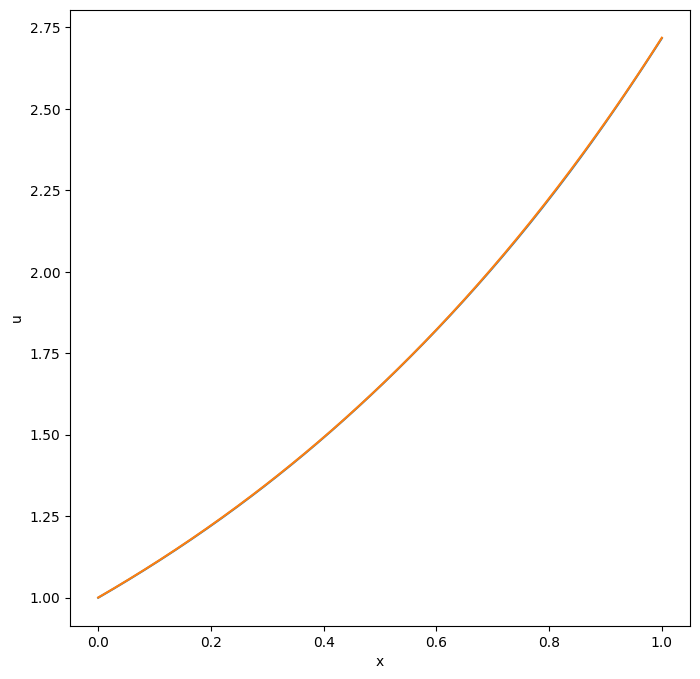

In [8]:
from pina.plotter import Plotter

# plotting the loss
plotter = Plotter()
plotter.plot(trainer=trainer)

The solution is completely overlapped with the actual one. We can also plot easily the loss:

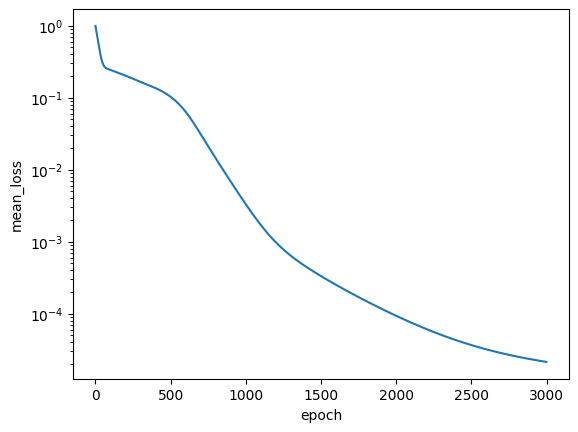

In [9]:
plotter.plot_loss(trainer=trainer, metric='mean_loss', log_scale=True)